In [48]:
import pandas as pd
import numpy as np

import nltk
from nltk.stem import PorterStemmer
import re
import pickle
import time
from colorama import Fore, Back, Style

from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


import urllib.request
import webbrowser

In [49]:
from nltk.corpus import stopwords
quit_words = ['quit', 'bye', 'thanks', 'exit', 'thankyou', 'thank you', 'thanku']

greetings = ["hello","hey","hi","hello","how are you?","how's it going","help","i need some help","i need help","hi there",
"hello there","hi chatbot","hi great learning","hi greatlearning","anybody there?","are you a chatbot?",
"are you human?","greetings!","nice to meet you","what's up?","good morning","good afternoon","good evening",
"good night","are you real?","you're a machine?","tell me something","what can you do?","how can you help me",
"i have a question","can you help me","what's your name","greetings","morning","afternoon","hello chatbot","check","test","howdy",
"morning","afternoon","evening"]

# root to be used as random state
root = 42

In [50]:
## Spelling correction
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('big_ml.txt', encoding="utf8").read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [51]:
# Common functions definition

def cleanText(s1):
    ps = PorterStemmer()
    text = s1.lower()
    text = re.sub(r'[0-9]*','',text)
    text = re.sub(r'^([a-z],[A-Z])*','',text)
    text = re.sub(r'\s\s+',' ',text)
    word_list = []
    for word in nltk.word_tokenize(text):
        
#        print("Original word:", word)  ## debug print
        word = correction(word)
#        print("corrected word:", word)  ##debug print
        if(word not in stopwords.words('english')):
            ps.stem(word)
            word_list.append(word)
    text = word_list

### Removed below line after adding code for spelling correction
#    text = [ps.stem(word) for word in nltk.word_tokenize(text) if word not in stopwords.words('english')]
    text = ' '.join(text)
#    print("Final sentence:", text)  ## debug print
    return text

# After prediction convert tag to response
def getResponse(tag):
    try:
        if(resp_dict[tag]):
            response = resp_dict[tag]
            return response
        else:
            print('Response not found.. Please try another query.')
    except:
        print('Response not found for:', tag)
        print('I will update my knowledge soon :)')

def process_response(response):
    if(response[0:4]=='Link'):
        url = response[5:]
#        webbrowser.open(url)
        print("Bot: url to open is {}".format(url))
    else:
        print("Bot: ", response)

def store_new_query(query):
    with open("non_corpus_queries.txt", "a") as f:
        str = inp_text + "\n"
        f.write(str)

In [52]:
# test code

st = "find about neaurel networ"
cleanText(st)

'find neural network'

In [53]:
df = pd.read_csv("Corpus_1.csv")
df.columns = ['query', 'response', 'tag']
df = df.dropna()


In [54]:
df.head(2)

,query,response,tag
0,Hello,Hello! how can I help you ?,hello
1,Linear Regression formula,Link:https://en.wikipedia.org/wiki/Linear_regr...,Linear regression


In [55]:
df['transformed_query'] = df['query'].apply(cleanText)

In [56]:
# Preparing list of queries to compare to later to store new queries
query_list = df['query'].tolist()
query_list = [i.lower() for i in query_list]

In [57]:
# encoding the target column
le = LabelEncoder()
df['tag_encoded'] = le.fit_transform(df['tag'])

In [58]:
# Converting with bag of words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(1, 2))
X = cv.fit_transform(df['transformed_query']).toarray()

y = df['tag_encoded']

In [59]:
# Creating dataframe to visualize data
temp_name = cv.get_feature_names()
temp = pd.DataFrame(X, columns=temp_name)

In [60]:
# Create dictionary for tag to response
temp = df[['tag_encoded', 'response']]
temp = temp.groupby(['tag_encoded']).max()
resp_dict = temp.to_dict()
resp_dict = resp_dict['response']

#### Test code

In [61]:
# # Test code to check accuracy
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = root)

In [62]:
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.ensemble import RandomForestClassifier


In [63]:
#mnb = MultinomialNB()
#model = mnb.fit(X_train, y_train)

# rf = RandomForestClassifier()
# model = rf.fit(X_train,y_train)

# from xgboost import XGBClassifier
# xgb = XGBClassifier()
# model = xgb.fit(X_train, y_train)

In [64]:
# y_pred = model.predict(X_test)

In [65]:
# from sklearn.metrics import accuracy_score
# score = accuracy_score(y_test, y_pred)
# print(score)

#### Test code ends here

In [66]:
# Fitting naive bayes algorithm
mnb = MultinomialNB()
model = mnb.fit(X, y)

# Mohit - we are taking accuracy on data on which we have trained model
y_pred = model.predict(X)
print("Validation Accuracy:",metrics.accuracy_score(y, y_pred))

with open("bot_model.pickle",'wb') as f:
    pickle.dump(model,f)

Validation Accuracy: 0.9446494464944649


In [67]:
# Xgboost predictor
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

model_xg = XGBClassifier()
model_xg = model_xg.fit(X, y)
y_pred = model_xg.predict(X)

print("Validation Accuracy:",metrics.accuracy_score(y, y_pred))

with open("bot_model.pickle",'wb') as f:
    pickle.dump(model_xg,f)

Validation Accuracy: 0.933579335793358


In [68]:
# Random forest classifier

model_rf = RandomForestClassifier()
model_rf = model_rf.fit(X, y)
y_pred = model_rf.predict(X)
print("Validation Accuracy:",metrics.accuracy_score(y, y_pred))

with open("bot_model.pickle",'wb') as f:
    pickle.dump(model_xg,f)

Validation Accuracy: 0.992619926199262


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Model building ends here

#### Test code starts

In [69]:
# Predict using model
def process_input(s1):
#    s1 = 'What is linear regression?'
    s1 = cleanText(s1)
    l1=[]
    l1.append(s1)
    ldf = pd.DataFrame(l1, columns= ['query'])
    return ldf

In [70]:
# Test code to be removed
ss = 'search for library'
query_df = process_input(ss)
X_test     = cv.transform(query_df['query']).toarray()
prediction = model.predict(X_test)
prediction_proba = model.predict_proba(X_test)
print(prediction)
print(prediction_proba.max())
print(prediction_proba)
print(model.classes_)
resp       = getResponse(prediction[0])
print(resp)


[13]
0.7303704533636751
[[0.00313279 0.00313279 0.00898855 0.00464972 0.01050191 0.05785072
  0.0542467  0.01177928 0.05514747 0.00888523 0.00310448 0.00155928
  0.04665063 0.73037045]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Sklearn


In [71]:
from matplotlib import pyplot as plt

<BarContainer object of 14 artists>

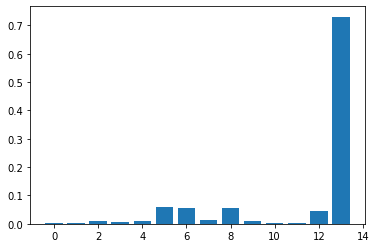

In [72]:
plt.bar(model.classes_, prediction_proba[0])

#### Testing code end here

In [73]:
# # Predict using model
# def process_input(s1):
# #    s1 = 'What is linear regression?'
#     s1 = cleanText(s1)
#     l1=[]
#     l1.append(s1)
#     ldf = pd.DataFrame(l1, columns= ['query'])
#     return ldf
    

### Start of prediction flow

#### Using pickle

In [74]:
# Trying pickle with model
pickle_in = open('./bot_model.pickle','rb')
classifier = pickle.load(pickle_in)
pickle_in.close()

### Original code to run for bot

In [75]:
# Landing message
print(Fore.RED +  "Hello. I am your machine learning assistant")
print("I can help you with your learning journey.")
print(Fore.CYAN + "You can ask me questions around algorithms and learn new stuff!!")
print(Style.RESET_ALL)
time.sleep(4)

# Get input from user
inp_text=''
while(inp_text != 'quit'):
    inp_text = input('User: ')
    
    if (inp_text in quit_words):
        inp_text = 'quit'
    
    if (inp_text in greetings):
        inp_text = 'greeting'
        
    if(inp_text != 'quit'):
        if(inp_text != 'greeting'):
            if(inp_text.lower() not in query_list):
                store_new_query(inp_text)
            query_df   = process_input(inp_text)
            print("Input for model:", query_df)
            X_test     = cv.transform(query_df['query']).toarray()
            prediction = classifier.predict(X_test)
            max_probab = classifier.predict_proba(X_test).max()
            print("predicted value {} with probability {}".format(prediction, max_probab))
            if (max_probab > .80):
                resp       = getResponse(prediction[0])
                process_response(resp)
            else:
                print("Sorry I am currently not trained for this question.")
        else:
            print("Hello! how can I help you ?")
    else:
        print("Thanks. See you again")

Hello. I am your machine learning assistant
I can help you with your learning journey.
You can ask me questions around algorithms and learn new stuff!!

User: what is sklearn
Input for model:      query
0  sklearn
predicted value [13] with probability 0.937166154384613
Bot:  Sklearn
User: what liibraries can be used for ml
Input for model:                query
0  libraries used ml
predicted value [13] with probability 0.7760431170463562
Sorry I am currently not trained for this question.
User: ok
Input for model:   query
0      
predicted value [12] with probability 0.5411382913589478
Sorry I am currently not trained for this question.
User: thanks
Thanks. See you again
